## Implementing Dynamic Programming and Monte Carlo methods to find the optimal policy on the Gridworld and Blackjack environments.

In [1]:
import numpy as np
import sys
from gridworld import GridworldEnv
%matplotlib inline

import matplotlib
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from collections import defaultdict
from blackjack import BlackjackEnv
matplotlib.style.use('ggplot')

### Dynamic Programming methods on Gridworld problem

#### To know more about GridWorld problem, read this [blog](https://medium.com/analytics-vidhya/grid-a-grid-world-environment-based-on-openai-gym-725189dcada6)


In [2]:
env = GridworldEnv()

### Implement Policy Evaluation

In [3]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001, draw=False):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        # TODO: Implement!
        delta = 0
        for s in range(env.nS):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + discount_factor * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if draw: plot(V,policy,draw_vals=True)
        if delta < theta:
            break
    return np.array(V)

In [4]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env)

In [5]:
# Test: Make sure the evaluated policy is what we expected
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

In [6]:
def q_from_v(env, V, s, gamma=1):
    q = np.ones(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

### Implement Policy Iteration

In [7]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Implement this!
        for s in range(env.nS):
            q = q_from_v(env, v, s, discount_factor)
 
            best_a = np.argwhere(q==np.max(q)).flatten()
            policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
            
        break
    
    return policy

In [8]:
policy = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 3]
 [0 0 3 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[  0.         -13.99993529 -19.99990698 -21.99989761 -13.99993529
 -17.9999206  -19.99991379 -19.99991477 -19.99990698 -19.99991379
 -17.99992725 -13.99994569 -21.99989761 -19.99991477 -13.99994569
   0.        ]

Reshaped Grid Value Function:
[[  0.         -13.99993529 -19.99990698 -21.99989761]
 [-13.99993529 -17.9999206  -19.99991379 -19.99991477]
 [-19.99990698 -19.99991379 -17.99992725 -13.99994569]
 [-21.99989761 -19.99991477 -13.99994569   0.        ]]



In [9]:
# Test the value function
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

### Implement Value Iteration

In [10]:
def value_iteration(env, theta=1e-8, discount_factor=0.7):
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    # Implement!
    while True:
        delta = 0
        for s in range(env.nS):
            v_s = V[s] # store old value
            q_s = q_from_v(env, V, s, discount_factor) # the action value function is calculated for all actions
            V[s] = max(q_s) # the next value of the state function is the maximum of all action values
            delta = max(delta, abs(V[s] - v_s))
        if delta < theta:break
    # lastly, at convergence, we can get a (optimal) policy from the optimal state value function
    policy = policy_improvement(env, V, discount_factor)         
    return policy, V

In [11]:
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 3]
 [0 0 3 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[3.33333331 2.33333332 1.63333332 1.14333333 2.33333332 1.63333332
 1.14333333 1.63333331 1.63333332 1.14333333 1.63333331 2.33333331
 1.14333333 1.63333331 2.33333331 3.33333331]

Reshaped Grid Value Function:
[[3.33333331 2.33333332 1.63333332 1.14333333]
 [2.33333332 1.63333332 1.14333333 1.63333331]
 [1.63333332 1.14333333 1.63333331 2.33333331]
 [1.14333333 1.63333331 2.33333331 3.33333331]]



In [12]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

### Monte Carlo Prediction to estimate state-action values

#### To know more about the blackjack environment, read this [blog](https://towardsdatascience.com/cracking-blackjack-part-1-31da28aeb4bb)

In [13]:
env = BlackjackEnv()

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [14]:
def generate_episode(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 20 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [15]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([discount_factor**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
    V = {k: np.mean(v) for k, v in returns.items()}
    return V    

In [16]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

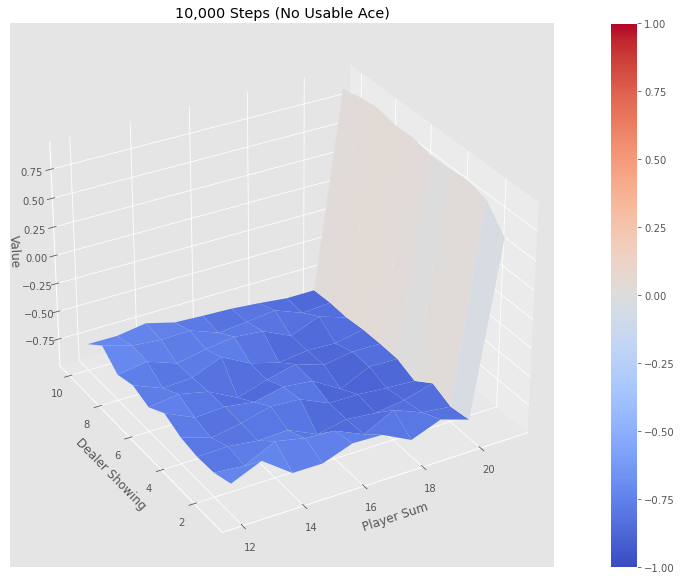

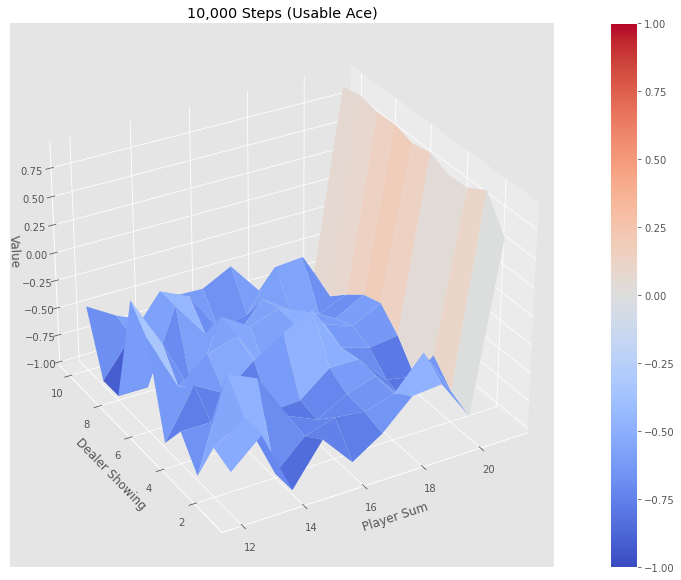

Episode 500000/500000.

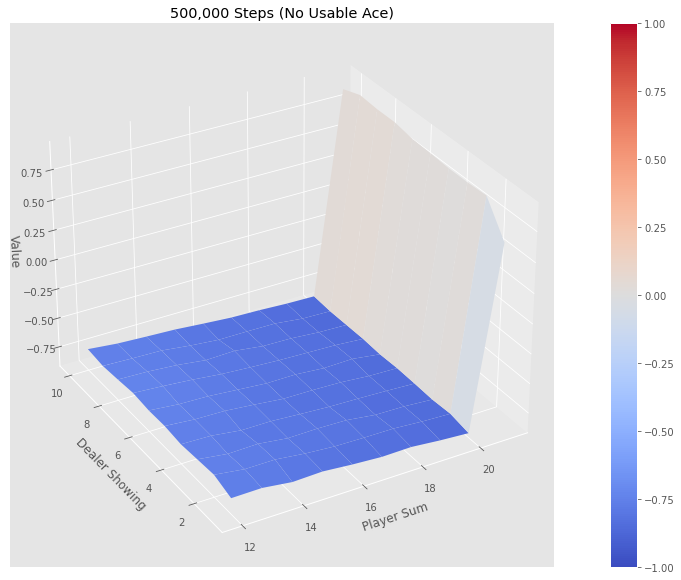

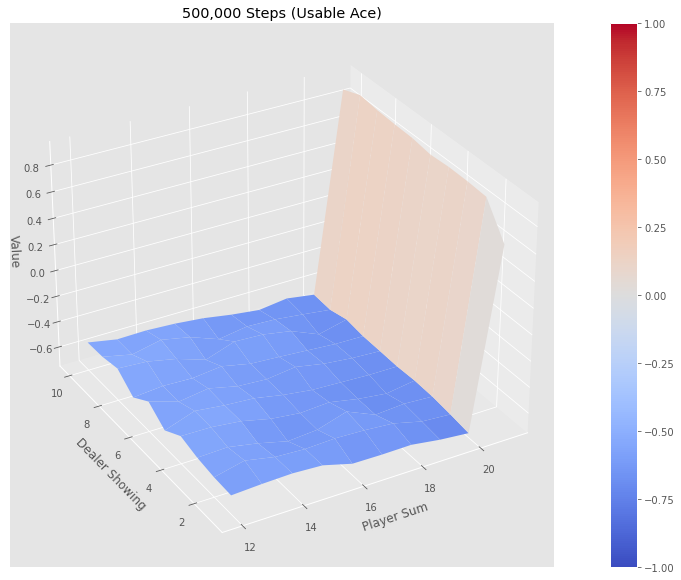

In [17]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plot_value_function(V_500k, title="500,000 Steps")

### On-policy first-visit Monte Carlo Control algorithm

In [18]:
def make_epsilon_greedy_policy(Q, epsilon, nA):  
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pass
        policy_fn = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_fn[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_fn

In [19]:
# Additional functions to organize the codes

def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def update_Q_GLIE(env, episode, Q, N, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
    return Q, N

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [20]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    nA = env.action_space.n
    
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, nA)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, discount_factor)
    
    return Q, policy

In [21]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

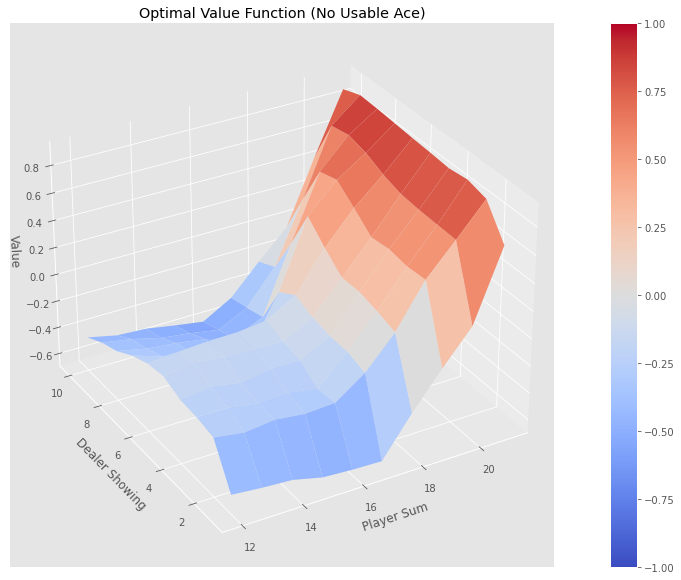

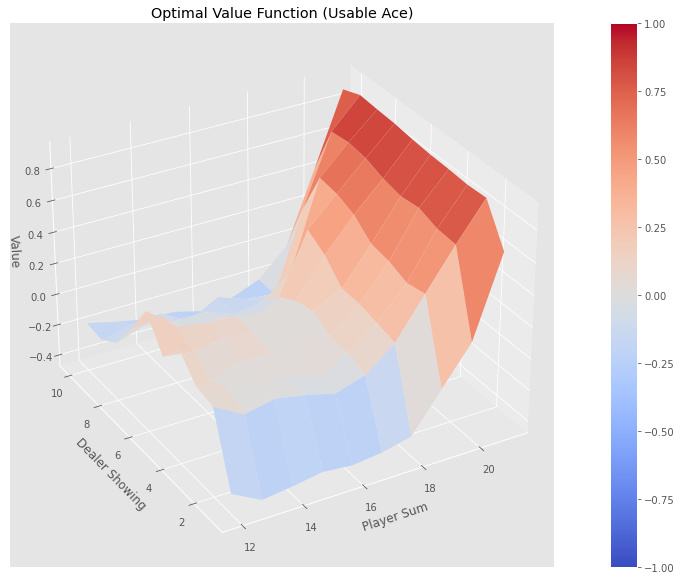

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

plot_value_function(V, title="Optimal Value Function")

### off-policy every-visit Monte Carlo Control using Weighted Important Sampling algorithm

In [23]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [24]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    nA = env.action_space.n
    epsilon = 0.1
    
    def policy_fn(observation):
        pass
        policy_fn = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q)
        policy_fn[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_fn

In [25]:
def update_Q_for_sampling(env, episode, Q, policy, discount_factor):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([discount_factor**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + policy*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [26]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    nA = env.action_space.n
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # set the value of epsilon
        epsilon = 0.1
        alpha = 0.001
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q_for_sampling(env, episode, Q, alpha, discount_factor)
        
    return Q, target_policy

In [27]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

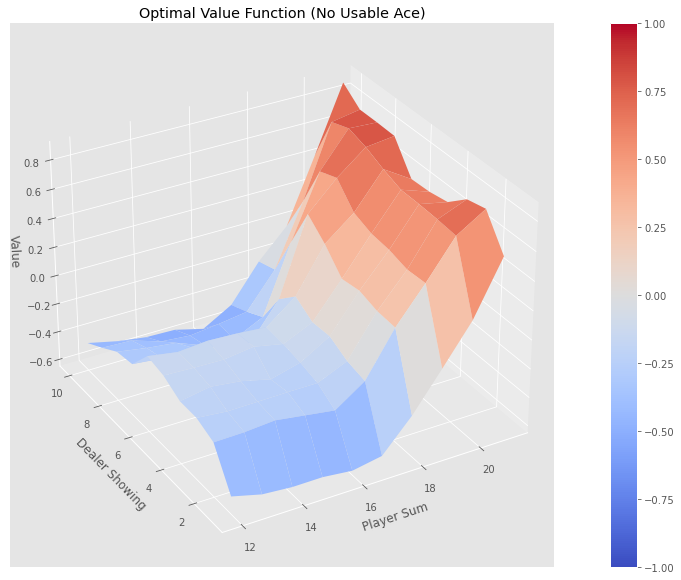

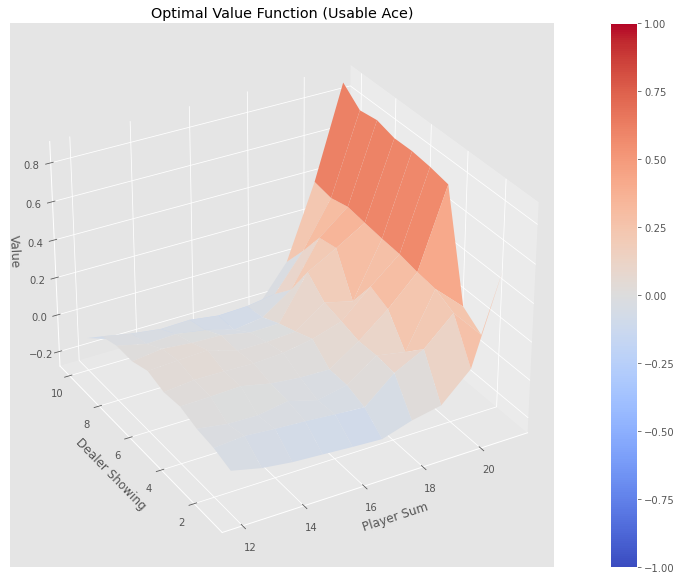

In [28]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value

plot_value_function(V, title="Optimal Value Function")